<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/MSFT_learning_02_computervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **下載與檢視 資料集**
1. dataset, dataloader
2. 檢視相關資訊

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [ ]:
# datasets
train_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [ ]:
# dataloader
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = 64,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = 64,
                             shuffle = True)

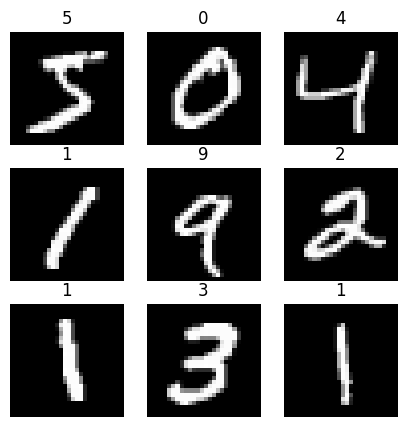

In [6]:
# 隨機檢視圖片
train_dataset[0]

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3

for i in range(9):
    figure.add_subplot(cols, rows, i+1)
    plt.imshow(train_dataset[i][0].squeeze(), cmap="gray")
    plt.title(train_dataset[i][1])
    plt.axis("off")

In [7]:
# 檢視資料資訊
print(f"訓練資料數量: {len(train_dataset)}")
print(f"測試資料數量: {len(test_dataset)}\n")
print(f"圖片資料: {train_dataset[0][0].size()}")

訓練資料數量: 60000
測試資料數量: 10000

圖片資料: torch.Size([1, 28, 28])


# **Model & functions**
1. Model_1
2. Func : train, test, training loop ...

In [8]:
!pip install torchinfo

In [9]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

## Model_1

In [10]:
# Model structure & build model
device = "cuda" if torch.cuda.is_available() else "cpu"

class simpleNET(nn.Module):
    def __init__(self):
        super(simpleNET, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        probs = self.layer_1(x)
        return probs

model_1 = simpleNET().to(device)
summary(model_1)

Layer (type:depth-idx)                   Param #
simpleNET                                --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       7,850
│    └─LogSoftmax: 2-3                   --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

## Train function

In [34]:
# Train function
def train(model, dataloader, loss_fn, optimizer):
    model.train()

    total_loss, acc, count = 0, 0, 0

    for features, labels in dataloader:
        probs = model(features)
        loss = loss_fn(probs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss
        _, predicted = torch.max(probs, 1) # 找出probs 第一維度的最大值 -> 第一變數, 最大值是哪一個(較不重要, 所以使用_) / 第二變數, 最大值所在index (label)
        acc = acc + (predicted == labels).sum() # 僅計算, 預測label = True label
        count = count + len(labels)

        return total_loss.item()/count, acc.item()/count

In [35]:
#
print("Only for further understanding")
print(torch.max(model_1(next(iter(train_dataloader))[0]),1))

Only for further understanding
torch.return_types.max(
values=tensor([-1.5985, -1.3259, -0.8960, -0.8645, -1.0487, -1.8610, -1.4488, -1.1015,
        -0.3052, -1.4449, -1.8417, -0.9527, -1.5541, -0.5971, -0.8803, -1.4513,
        -1.6579, -0.8984, -1.5640, -1.1666, -1.4690, -0.3421, -1.2943, -1.7894,
        -1.1848, -0.6853, -1.4123, -1.6020, -1.6896, -1.5970, -1.1804, -1.6528,
        -1.1497, -1.3375, -1.3761, -1.7840, -1.5867, -1.4009, -1.2470, -0.7232,
        -0.9723, -1.4827, -1.3256, -1.6368, -1.3187, -0.6105, -1.1456, -1.2787,
        -1.0568, -1.5128, -1.9893, -2.0257, -1.3504, -1.2123, -1.7871, -1.0545,
        -1.6553, -1.5937, -1.0417, -0.8436, -1.2802, -1.5795, -1.7927, -1.6946],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 7, 5, 0, 7, 3, 0, 0, 0, 0, 0, 5, 0, 0, 7, 5, 0, 5, 3, 3, 0, 7, 6,
        3, 0, 0, 7, 5, 0, 0, 0, 0, 5, 0, 1, 5, 5, 5, 5, 5, 1, 5, 0, 5, 0, 0, 7,
        5, 1, 3, 5, 7, 0, 7, 0, 7, 1, 5, 0, 0, 5, 4, 1]))


In [39]:
# 測試 train function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                            lr=0.01)

loss, acc = train(model = model_1,
                  dataloader = train_dataloader,
                  loss_fn = loss_fn,
                  optimizer = optimizer)

print(f"Train -> Loss: {loss} | Accuracy: {acc}")

Train -> Loss: 0.024189934134483337 | Accuracy: 0.53125


## Test function

In [37]:
# Test function
def test(model, dataloader, loss_fn):
    model.eval()

    total_loss, acc, count = 0, 0, 0
    with torch.inference_mode():
        for features, labels in dataloader:
            probs = model(features)
            loss = loss_fn(probs, labels)
            # accumulate total_loss
            total_loss = total_loss + loss
            _, predicted = torch.max(probs, 1)
            # accumulate accuracy predict
            acc = acc + (predicted == labels).sum() # 僅計算, 預測label = True label
            count = count + len(labels)
    return total_loss.item()/count, acc.item()/count

In [40]:
# 測試 test function
loss_fn = nn.CrossEntropyLoss()

loss, acc = test(model = model_1,
                 dataloader = test_dataloader,
                 loss_fn = loss_fn)

print(f"Test -> Loss: {loss} | Accuracy: {acc}")

Test -> Loss: 0.021957235717773436 | Accuracy: 0.6407


## Training loop function